In [37]:
from bs4 import BeautifulSoup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
sns.set_context('notebook')
import re
import requests as rq
import json
import google_helper as ggl_h
from scipy import stats

# Pre-Processing the datas

In [38]:
cantons_json_path = "data/ch-cantons.topojson.json"
cantons_csv_path = "data/P3_GrantExport.csv"

data = pd.read_csv(cantons_csv_path, sep=';')

We first read the datas from the CSV file and we drop the columns we don't need in the dataframe.

In [39]:
data = data.drop([ "Project Title", "Project Title English", "Responsible Applicant", "Funding Instrument", "Funding Instrument Hierarchy", "Discipline Number", "Discipline Name", "Discipline Name Hierarchy", "Start Date", "End Date", "Keywords"], axis=1)
data.head()

﻿"Project Number"                                        Institution  \
0                  1                                                NaN   
1                  4  Faculté de Psychologie et des Sciences de l'Ed...   
2                  5  Kommission für das Corpus philosophorum medii ...   
3                  6  Abt. Handschriften und Alte Drucke Bibliothek ...   
4                  7                       Schweiz. Thesauruskommission   

                                University Approved Amount  
0                     Nicht zuteilbar - NA        11619.00  
1                Université de Genève - GE        41022.00  
2  NPO (Biblioth., Museen, Verwalt.) - NPO        79732.00  
3                   Universität Basel - BS        52627.00  
4  NPO (Biblioth., Museen, Verwalt.) - NPO       120042.00

We are interested in the approved amount, so let's see if we have any non-numeric value first.

In [40]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
 
notNumbers = set([n for n in data['Approved Amount'] if not is_number(n)])
notNumbers

{'data not included in P3'}

As we see, there is a non-numerical value which is 'data not included in P3'. Now let's check what kind of values we have in the universities

In [41]:
universityValues = set(data['University'])

If look at the set, there are 2 values that won't be useful (NaN and 'Nicht zuteilbar - NA'). The NaN value is indicated in the description of the data ('Ce champ n’est rempli que dans le cas où la recherche est conduite dans une institution suisse, sinon ce champ est **vide**').

Hence we drop the rows where the value in the approved amount column is not a number (here "data not included in P3") since we can't get a numeric value from this.

Then we drop the lines where the university column equals "Nicht zuteilbar - NA" and "NaN" as we cannot find the cantons where they are located.

In [42]:
count_amount = data[data["Approved Amount"].isin(notNumbers)].shape[0]
count_uni = data[data["University"] == "Nicht zuteilbar - NA"].shape[0] + data[pd.isnull(data["University"])].shape[0]

print("Percentage of amount data not in P3 : ", (count_amount / data.shape[0]) * 100,"%")
print("Percentage of University not defined : ", (count_uni / data.shape[0]) * 100,"%")

before_deletion_size = data.shape[0]

print("Number of rows in the data before deletion : ", before_deletion_size)

data = data[~data["Approved Amount"].isin(notNumbers)]
data = data[data["University"] != "Nicht zuteilbar - NA"]
data = data.dropna(subset=['University'])

print("Number of rows in the data after deletion : ", data.shape[0])
print("Percentage of row deleted : ", ((before_deletion_size - data.shape[0]) / before_deletion_size) * 100, "%")

data = data.reset_index(drop=True)
data.head()

Percentage of amount data not in P3 :  17.055136081539494 %
Percentage of University not defined :  24.349294189372976 %
Number of rows in the data before deletion :  63969
Number of rows in the data after deletion :  48283
Percentage of row deleted :  24.52125248167081 %


﻿"Project Number"                                        Institution  \
0                  4  Faculté de Psychologie et des Sciences de l'Ed...   
1                  5  Kommission für das Corpus philosophorum medii ...   
2                  6  Abt. Handschriften und Alte Drucke Bibliothek ...   
3                  7                       Schweiz. Thesauruskommission   
4                  8  Séminaire de politique économique, d'économie ...   

                                University Approved Amount  
0                Université de Genève - GE        41022.00  
1  NPO (Biblioth., Museen, Verwalt.) - NPO        79732.00  
2                   Universität Basel - BS        52627.00  
3  NPO (Biblioth., Museen, Verwalt.) - NPO       120042.00  
4              Université de Fribourg - FR        53009.00

To the end we filtered 24% of the data (which is non-negligeable but necessary).

# Find each university's canton

Now that the data is pre-processed, we need to map each university to the right canton. We first fetch the set of universities' name from the dataframe.

In [43]:
universities = data.University.unique()
' | '.join(universities[:5])

'Université de Genève - GE | NPO (Biblioth., Museen, Verwalt.) - NPO | Universität Basel - BS | Université de Fribourg - FR | Universität Zürich - ZH'

Once we have these names, we try to get the appropriate canton using the following steps (with our helper file google_helper):
- get the name of the university (splitting by dash and taking the first part)
- use the Google Maps Geocoding API to fetch the corresponding canton (in 'administrative_area_level_1')
- it's possible that some names does not return any results, in this case we switch to another API, which is Google Places, that fetches the longitude and latitute coordinates for a place
- once we have these coordinates, we use reverse geocoding to get the canton name

Doing it in two steps decreased the number of locations not found from 48 to 18.

In [44]:
cantons_ids_google = ggl_h.canton_ids(universities)
' | '.join(map(str, cantons_ids_google[:5]))

"('Université de Genève', 'GE') | ('NPO (Biblioth., Museen, Verwalt.)', None) | ('Universität Basel', 'BS') | ('Université de Fribourg', 'FR') | ('Universität Zürich', 'ZH')"

So we have now each university mapped to a canton, but we may miss some (i.e mapped with None), or some that are mapped to a place not in Switzerland (for instance there was an institution based in Rome).

Using the JSON topo for the map, we can get all the correct cantons ids, and build two list (one for correct mapped cantons and one for not found or not correctly mapped cantons).

In [45]:
input_file = open(cantons_json_path, 'r', encoding='utf-8')
canton_ids = [elem['id'] for elem in json.load(input_file)['objects']['cantons']['geometries']]

correct     = [t for t in cantons_ids_google if t[1] in canton_ids]
not_correct = [t for t in cantons_ids_google if t[1] not in canton_ids]

Now we build manually a lookup for the university names that were incorrectly or not mapped.

In [46]:
#Build lookup manually
lookup = {
 'AO Research Institute': 'GR',
 'Allergie': 'BE',
 'Eidg. Forschungsanstalt für Wald,Schnee,Land': 'ZH',
 'Eidg. Material und Prüfungsanstalt': 'ZH',
 'Fachhochschule Nordwestschweiz (ohne PH)': 'SO',
 'Firmen/Privatwirtschaft': None, #private society/sector so no location available
 'Forschungsanstalten Agroscope': None, #organism split into multiple cantons., can't assume equal distribution
 'Forschungsinstitut für Opthalmologie': 'VS',
 'Forschungsinstitut für biologischen Landbau': 'AG',
 'Forschungskommission SAGW': 'BE',
 'Haute école pédagogique BE, JU, NE': 'JU',
 'Inst. de Hautes Etudes Internat. et du Dév': 'GE',
 'Istituto Svizzero di Roma': None, #private fondation, in Rome
 'NPO (Biblioth., Museen, Verwalt.)': None, #non-profit organizations, can't assume equal distribution
 'Physikal.': None, #swiss physical society, can't assume equal distribution
 'Schweiz. Hochschule für Logopädie Rorschach': 'SG',
 'Schweizer Kompetenzzentrum Sozialwissensch.': 'VD',
 'Swiss Center for Electronics and Microtech.': 'NE',
 'Swiss Institute of Bioinformatics': 'VD',
 'Weitere Institute': None, #other institutes, can't assume equals distribution
 'Weitere Spitäler': None #other hospitals, can't assume equal distribution
}

In [47]:
map_ids = {**dict(correct), **lookup}

# Build the DataFrame 

We have know the mapping from university name to canton, so build the dataframe we proceed with the following steps:
+ add a new column 'Canton' in it, where the map is used to find the right canton according to the university name
+ keep only the 'Canton' and 'Approved Amount' columns
+ change the datatype of the values in the 'Approved Amount' column to be of type float
+ group by the cantons and sum the values aggregated

In [48]:
data_bis = data.copy()
data_bis['Canton'] = data_bis['University'].apply(lambda name: map_ids[name.split('-')[0].strip()])
data_bis = data_bis[['Canton', 'Approved Amount']]
data_bis['Approved Amount'] = data_bis['Approved Amount'].apply(lambda val : float(val))
data_grouped = data_bis.groupby('Canton').sum().reset_index()

In order to build the map, it's required to have every canton id present. So for each canton that is not already in the data frame, we add a new row (cantonId, 0).

In [49]:
cantons_missing = [[id_, 0] for id_ in canton_ids if id_ not in data_grouped.Canton.values]
df_missing = pd.DataFrame(cantons_missing, columns=['Canton', 'Approved Amount'])
data_grouped = data_grouped.append(df_missing, ignore_index=True)

Finally, we create a map of the coordinates values for each canton (we could have build it dynamically using BeautifulSoup and Selenium, but for 26 values, it was faster to do it manually). It will be used to draw markers on the map.

In [50]:
cantons_coordinates = {
    'ZH' : [47.377895, 8.541183],
    'BE' : [46.94909, 7.447357], 
    'LU' : [47.05, 8.3], 
    'UR' : [46.880826, 8.639446], 
    'SZ' : [47.020546, 8.658332], 
    'OW' : [46.897214, 8.24722], 
    'NW' : [46.95972, 8.366674], 
    'GL' : [47.033329, 9.066666], 
    'ZG' : [47.169441, 8.516663], 
    'FR' : [46.806103, 7.162775], 
    'SO' : [47.208331, 7.537513], 
    'BS' : [47.567, 7.583], 
    'BL' : [47.466667, 7.733333], 
    'SH' : [47.700001, 8.633333], 
    'AR' : [47.383329, 9.266671], 
    'AI' : [47.330828, 9.408615], 
    'SG' : [47.416667, 9.366667], 
    'GR' : [46.85, 9.533333],
    'AG' : [47.4, 8.05], 
    'TG' : [47.556, 8.8965], 
    'TI' : [46.2, 9.016667], 
    'VD' : [46.521, 6.631], 
    'VS' : [46.227778, 7.358611], 
    'NE' : [46.990281, 6.930567], 
    'GE' : [46.200013, 6.149985], 
    'JU' : [47.366667, 7.35]
}

We can now create the map, but before hand we want to have a nice treshold scale that is readable.

In [51]:
def get_exponent(x):
    if(x == 0):
        return 0
    else:
        return np.floor(np.log10(np.abs(x))).astype(int)

data_grouped['Approved Amount Magnitude'] = data_grouped['Approved Amount'].apply(get_exponent)
thresh_scale = np.unique(data_grouped['Approved Amount Magnitude'].values)
thresh_scale = list(np.delete(thresh_scale, 0))

In [52]:
import locale 
locale.setlocale(locale.LC_ALL, '')

swiss_map = folium.Map(location=[47, 8], zoom_start=8)
swiss_map.choropleth(geo_path=cantons_json_path, 
                     data=data_grouped,
                     columns=['Canton', 'Approved Amount Magnitude'],
                     threshold_scale=thresh_scale,
                     key_on='feature.id',
                     fill_opacity = 0.8,
                     line_opacity=0.4,
                     topojson='objects.cantons',
                     fill_color='BuPu',
                     legend_name = 'Grant money for each Swiss canton'
                    )

for key, value in cantons_coordinates.items():
    if(value != None):
        amount = locale.currency(data_grouped[data_grouped['Canton'] == key]['Approved Amount'].values[0], grouping=True)
        folium.Marker(value, popup=key + ' - ' + amount).add_to(swiss_map)
        
swiss_map.save('swiss_map.html')

In [53]:
#Display the map
swiss_map

In case you can't see the map, here's a screenshot of what it looks like (the markers display the amount for the canton when you click on it). If you want to see it interactively, you can download the HTML page (swiss_map.html) in the project directory.

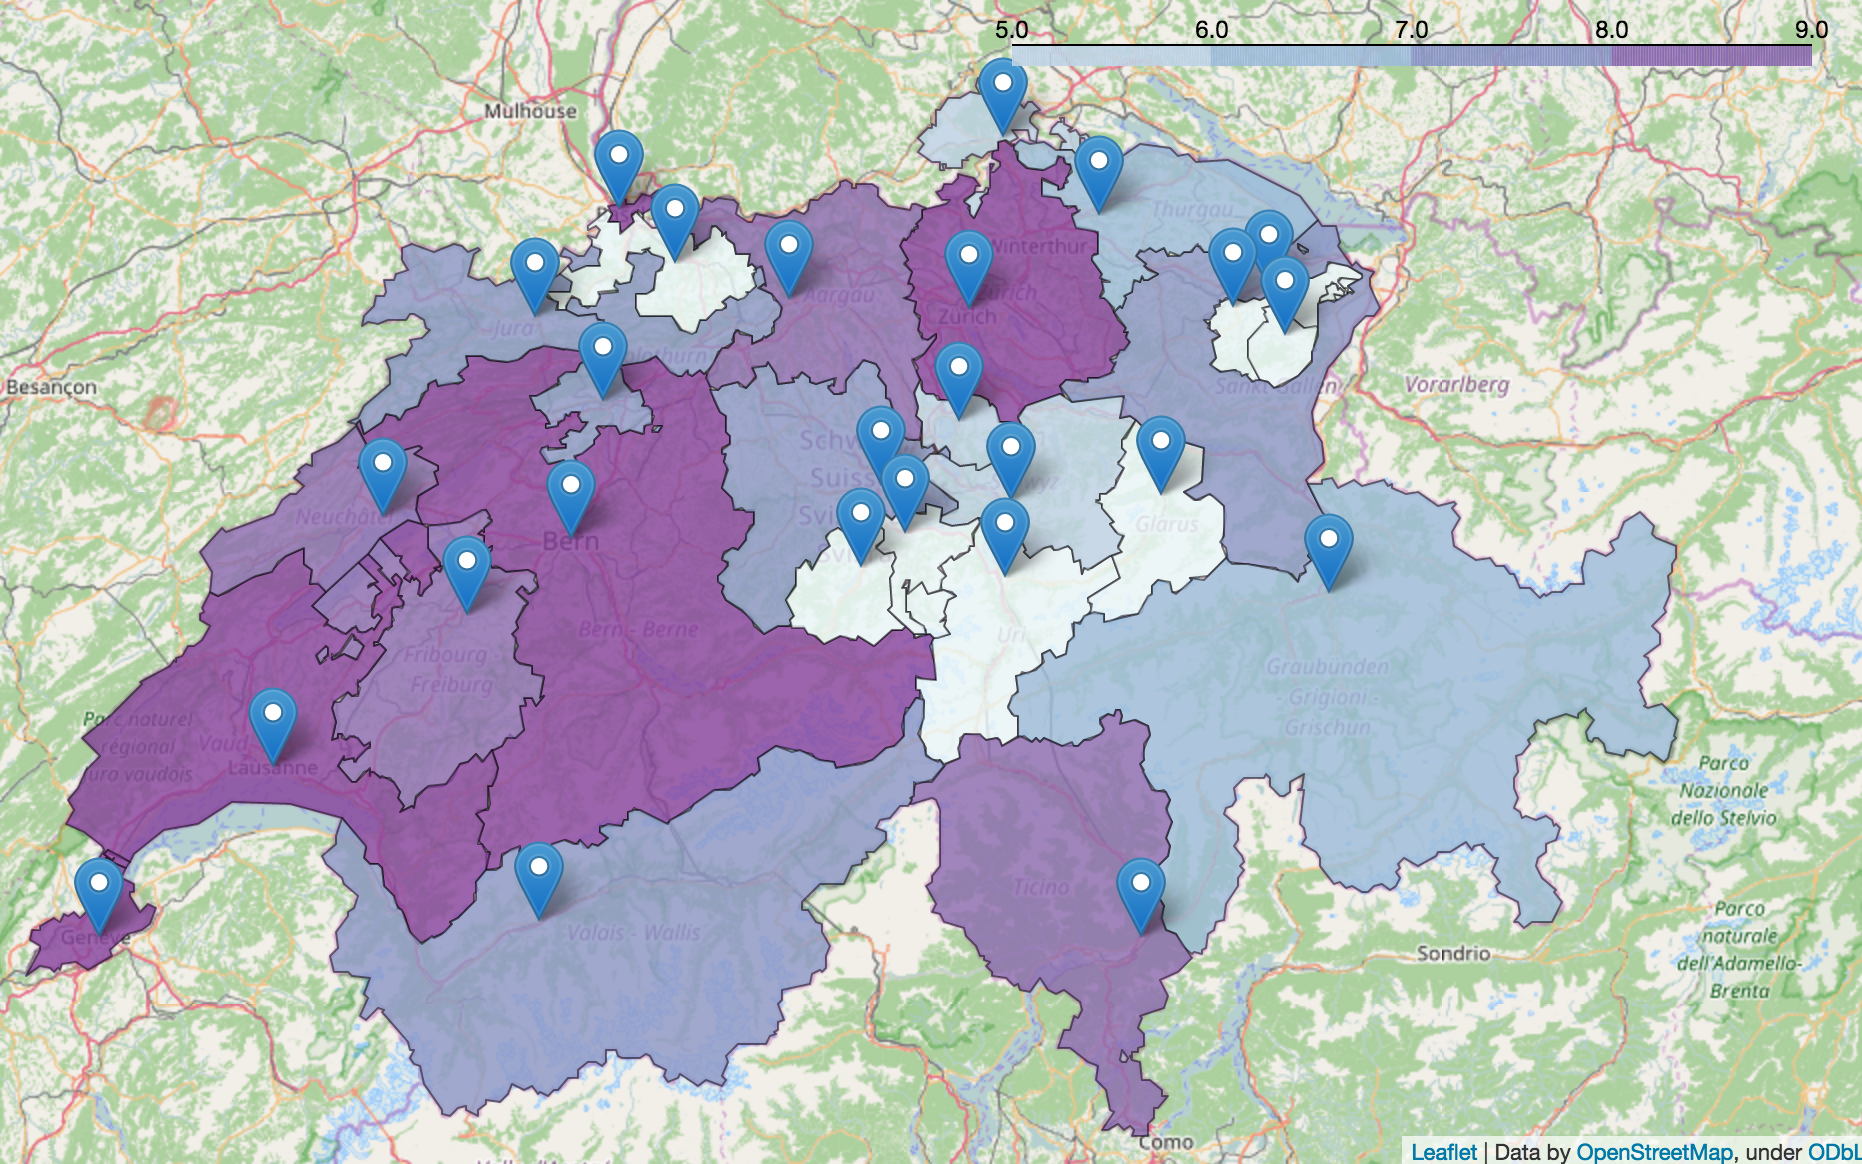

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image('swiss_map.png') 

# Run some statistical tests

In [18]:
project_amounts = data_bis.copy()
projects_amount_description = project_amounts.describe()
population_mean = project_amounts.mean() 
projects_amount_description

Approved Amount
count     4.828300e+04
mean      2.658377e+05
std       3.257335e+05
min       0.000000e+00
25%       8.960600e+04
50%       1.885930e+05
75%       3.324195e+05
max       1.548775e+07

We plot the data in order to have a better comprehension of it. We thus obtain the number of projects in between amount values.

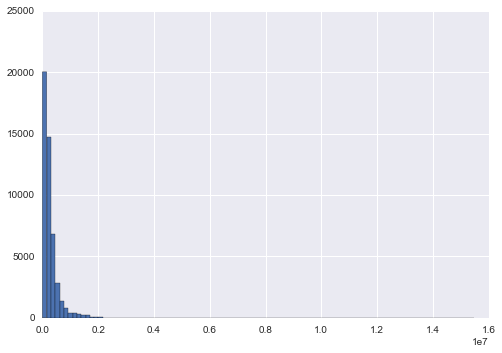

In [19]:
project_amounts['Approved Amount'].hist(bins = 100)         

We remove outliers to have a better visualization. We know that some projects have unusual high approved amounts. We thus remove the 5% top amounts.

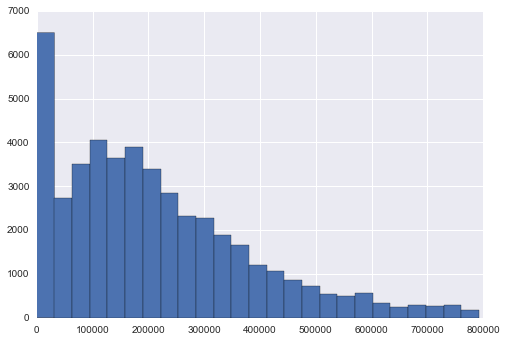

In [20]:
high_percentile = np.percentile(project_amounts['Approved Amount'], 95)
project_amounts_without_outliers = project_amounts[project_amounts['Approved Amount'] <= high_percentile]
project_amounts_without_outliers['Approved Amount'].hist(bins = 25)

We now want to know if there is a  statistically significant difference between each Cantons in terms of amounts injected. We thus will apply a hypothesis testing on each sub-sample (Canton distribution) with our null hypothesis being: 

     H0 := "Canton X has no significant difference in mean with the total population of approved amounts"


Rejecting it would mean that we found out that there is a statistically difference in mean of a certain Canton with the global distribution.


We will apply the test between a sub-sample and the global population, store the statistics in a dataframe and then conclude depending on the obtained pvalues.

The test will be applied to cantons with n > 0 projects.


We have the choice between two different tests in our situation:
- One-sample t-test
- Mann-Whitney U test

T-test second assumption of our sample's normality is not validated. We can ignore it iff our data size n is big (per sub-sample) mainly > 20 #projects
Unlike t-test, Mann-whiteney u test does not require the assumption of normality.

We can start by assessing if each of one of our cantons has at least 20 projects:

In [21]:
project_counts = project_amounts.groupby(['Canton']).count()
project_counts[project_counts['Approved Amount'] < 20]

Approved Amount
Canton                 
SH                    1
SZ                    5
TG                   14
ZG                    7

We have 4 cantons with a sample size too low. We thus decide to apply the Mann-Whitney U test.

In [22]:
#solution with mann whitney u test
cantons = project_amounts['Canton'].unique()
sp = {}
for canton in cantons:
    canton_distr = project_amounts[project_amounts['Canton'] == canton]
    if len(canton_distr) > 1:
        sp[canton] = stats.mannwhitneyu(canton_distr['Approved Amount'], project_amounts['Approved Amount'])

tests = pd.DataFrame.from_dict(sp, orient='index')
#The implementation of mwu are one-sided values. 
#We thus need to multiply those values by 2 to obatain two-sided ones.
tests['pvalue'] = tests['pvalue']*2
tests   

statistic        pvalue
BS  111101457.0  1.316966e-07
JU    4230332.0  1.837260e-26
FR   44295023.0  1.517961e-20
BE  132325188.0  5.769131e-05
ZG      74372.5  1.030071e-02
VS    2645630.5  4.878959e-03
NE   36715357.5  2.701175e-05
GR     625664.0  3.617416e-03
ZH  334927623.5  5.115080e-02
TG     224754.5  2.994936e-02
VD  202444302.0  1.321119e-04
SO    5056286.0  8.688987e-05
TI   11859743.0  5.113357e-02
SG   10091418.5  1.794615e-13
SZ     116063.5  8.815687e-01
GE  153435646.0  9.233514e-06
AG   12816574.5  9.090548e-02
LU    5387212.0  1.844668e-14

We see that only 4 Cantons (AG, TI, SZ, ZH) have pvalue > 0.05. For all the others, we can thus conclude that they have a statistically significant difference in mean with the population. There are thus some possible difference of investment for this majority of cantons. It is expected since the amounts are highly influenced on the characteristics of each projects which themselves depend to the university's application domain and size. It would explain that each investment amount would be differently distributed between Cantons.

# BONUS

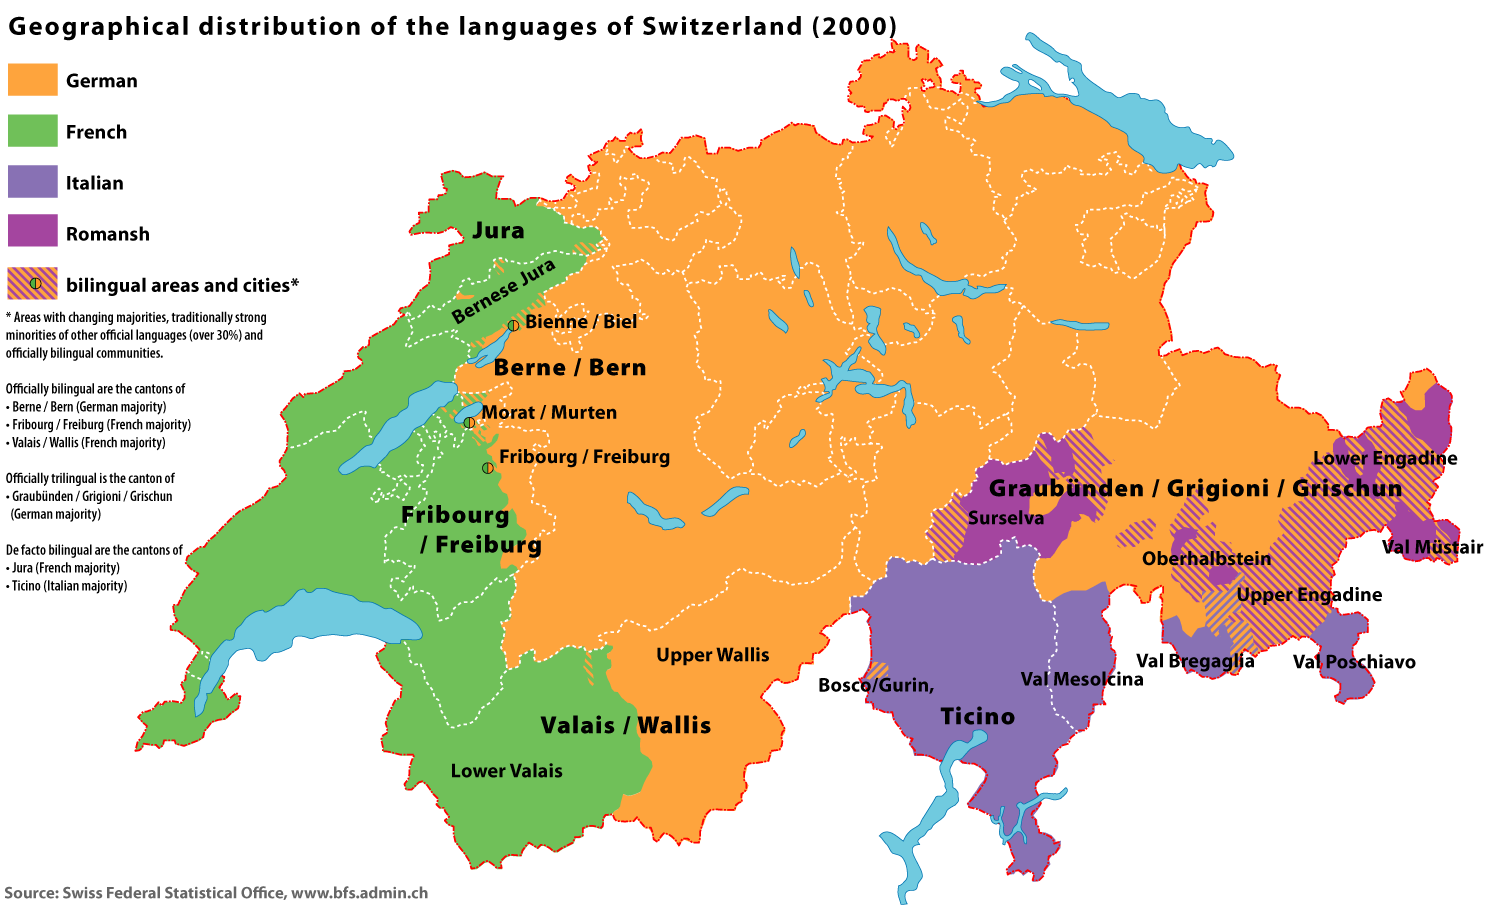

In [23]:
from IPython.display import Image
from IPython.core.display import HTML 
Image('rostigraben_map.png') 

Finding the exact topology of the Röstigraben map is difficult. But we can make a rough approximation, by first mapping each canton to its official languages. Again, we could use BeautifulSoup to extract those informations, but it's faster to do it manually since we only have 26 cantons to check.

In [24]:
cantons_official_languages = {
    'ZH' : ['de'],
    'BE' : ['de', 'fr'], 
    'LU' : ['de'], 
    'UR' : ['de'], 
    'SZ' : ['de'], 
    'OW' : ['de'], 
    'NW' : ['de'], 
    'GL' : ['de'], 
    'ZG' : ['de'], 
    'FR' : ['de', 'fr'], 
    'SO' : ['de'], 
    'BS' : ['de'], 
    'BL' : ['de'], 
    'SH' : ['de'], 
    'AR' : ['de'], 
    'AI' : ['de'], 
    'SG' : ['de'], 
    'GR' : ['de', 'it', 'roh'],
    'AG' : ['de'], 
    'TG' : ['de'], 
    'TI' : ['it'], 
    'VD' : ['fr'], 
    'VS' : ['de', 'fr'], 
    'NE' : ['fr'], 
    'GE' : ['fr'], 
    'JU' : ['fr'] #only one town speaks german
}

languages = set([item for list_ in cantons_official_languages.values() for item in list_])

To determine which university belongs to which language, we apply the following strategy:
+ if the language where the university lies is unique, we use it
+ otherwise we translate the institution name
+ if the institution name is not in the official languages of Switzerland, we try to detect the university name language
+ if we can't detect further, the exceptions are managed manually (see after).

In [33]:
from langdetect import detect

def mapping_cantons(name):
    """
    Return the canton associated with the university name 
    Parameters:
      name - the university name (of the form name - some_text).
    """
    id_ = map_ids[name]
    if(id_ is not None):
        return id_
    else:
        return lookup[name]

def mapping_used_language(t):
    """
    Returns the language of the university accorded to the rules described above
    Parameters:
      t - the tuple3(University_name, Institution_name, languages)
    """
    university_name = t[0]
    institution_name = t[1]
    languages = t[2]
    if(len(languages) == 1):
        return languages[0]
    else:
        if(str(institution_name) != 'nan'):
            lang = detect(institution_name)
            if(lang not in languages):
                return detect(university_name)
            else:
                return lang
        else:
            return detect(university_name)

data_rosti = data.copy()
data_rosti['Canton'] = data_rosti['University'].apply(lambda name: mapping_cantons(name.split('-')[0].strip()))
data_rosti = data_rosti.dropna(subset=['Canton']).reset_index()
data_rosti['Languages'] = data_rosti['Canton'].apply(lambda name: cantons_official_languages[name])
data_rosti['Approved Amount'] = data_rosti['Approved Amount'].apply(lambda val : float(val))
data_rosti['Mapped Language'] = data_rosti[['University', 'Institution', 'Languages']].apply(mapping_used_language, axis=1)
data_rosti.head()

index  ﻿"Project Number"  \
0      0                  4   
1      2                  6   
2      4                  8   
3      5                  9   
4      6                 10   

                                         Institution  \
0  Faculté de Psychologie et des Sciences de l'Ed...   
1  Abt. Handschriften und Alte Drucke Bibliothek ...   
2  Séminaire de politique économique, d'économie ...   
3  Institut für ökumenische Studien Université de...   
4          Ostasiatisches Seminar Universität Zürich   

                    University  Approved Amount Canton Languages  \
0    Université de Genève - GE          41022.0     GE      [fr]   
1       Universität Basel - BS          52627.0     BS      [de]   
2  Université de Fribourg - FR          53009.0     FR  [de, fr]   
3  Université de Fribourg - FR          25403.0     FR  [de, fr]   
4      Universität Zürich - ZH          47100.0     ZH      [de]   

  Mapped Language  
0              fr  
1              de  
2              fr  
3              de  
4              de

Now let's look at the different languages we mapped

In [26]:
list(data_rosti['Mapped Language'].unique())

['fr', 'de', 'it', 'en']

We see that there is still projects mapped to an english language.

In [27]:
data_rosti[data_rosti['Mapped Language'] == 'en']

index  ﻿"Project Number"  \
29264  31166             116818   
29279  31181             116846   
34567  36605             131204   
35267  37327             133215   
39717  41860             146375   
41504  43684             152035   
42861  45072             156362   
44323  46565             160665   
45344  47608             164245   

                                             Institution  \
29264  Biomaterials & Tissue Engineering Program AO R...   
29279  Biomaterials & Tissue Engineering Program AO R...   
34567  Biomaterials & Tissue Engineering Program AO R...   
35267  Biomaterials & Tissue Engineering Program AO R...   
39717  Biomaterials & Tissue Engineering Program AO R...   
41504  Biomaterials & Tissue Engineering Program AO R...   
42861  Biomaterials & Tissue Engineering Program AO R...   
44323                  Idiap Research Institute Martigny   
45344                  Idiap Research Institute Martigny   

                             University  Approved Amount Canton  \
29264      AO Research Institute - AORI         197000.0     GR   
29279      AO Research Institute - AORI         260000.0     GR   
34567      AO Research Institute - AORI           5000.0     GR   
35267      AO Research Institute - AORI           5000.0     GR   
39717      AO Research Institute - AORI         356250.0     GR   
41504      AO Research Institute - AORI         235000.0     GR   
42861      AO Research Institute - AORI         249918.0     GR   
44323  Idiap Research Institute - IDIAP         197576.0     VS   
45344  Idiap Research Institute - IDIAP         379339.0     VS   

           Languages Mapped Language  
29264  [de, it, roh]              en  
29279  [de, it, roh]              en  
34567  [de, it, roh]              en  
35267  [de, it, roh]              en  
39717  [de, it, roh]              en  
41504  [de, it, roh]              en  
42861  [de, it, roh]              en  
44323       [de, fr]              en  
45344       [de, fr]              en

There is not much data. Looking at Google, we found that the AO Research Institute - AORI is german and that Martigny should be mapped to the french part of the Valais.

In [28]:
data_rosti.loc[data_rosti['Institution'] == 'Idiap Research Institute Martigny', 'Mapped Language'] = 'fr'
data_rosti.loc[data_rosti['University'] == 'AO Research Institute - AORI', 'Mapped Language'] = 'de'

In [29]:
data_rosti_grouped = data_rosti[['Mapped Language', 'Approved Amount']].groupby('Mapped Language').sum().reset_index()
data_rosti_grouped

Mapped Language  Approved Amount
0              de     7.105831e+09
1              fr     5.103171e+09
2              it     1.152623e+08

We ensure that we didn't loose amounts between the first part and the bonus.

In [34]:
print(data_grouped['Approved Amount'].sum())
print(data_rosti_grouped['Approved Amount'].sum())

12324264474.330002
12324264474.329994


So to answer the question, there is a large difference with the italian part and the others. We can see in the map that the italian area is much less than the german and french ones.

However, the german area is larger than the french one but the difference in the amount of money granted for each is not that significative compared to their respective areas.